In [2]:
import pandas as pd

# Load the data from the provided file
file_path = 'PN_data.pkl'
data = pd.read_pickle(file_path)

N = data['N']
P = data['P']
P_err = data['P_err']

SOLVED. just need to find what `absolute_sigma` does

{'a': '(-4.9e-13, 7.06e-15)',
 'b': '(8.35e-08, 1.15e-09)',
 'c': '(-0.00465, 6.19e-05)',
 'd': '(85.2, 1.1)'}

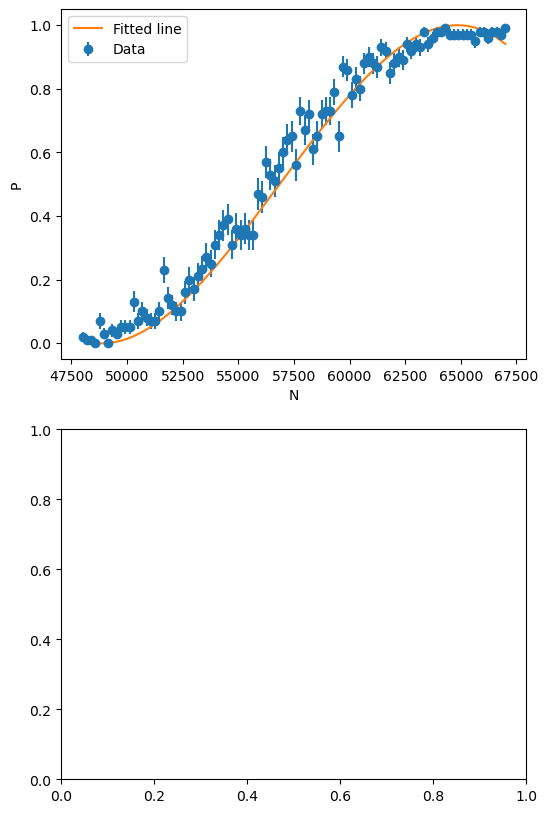

In [3]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def third_degree(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + c*x + d 

# Replace 0 uncertainties with 0.00001 so as to 
# not produce errors in the least squares estimation
P_err[P_err == 0.0] = 0.00001

# ------------------
# should maybe use starting values
# ------------------
popt, pcov = curve_fit(third_degree, N, P, sigma=P_err, absolute_sigma=True)

residual = P - third_degree(N, *popt)

fig, ax = plt.subplots(nrows=2, figsize=(6,10))

# Plotting fit over data
ax[0].errorbar(N, P, yerr=P_err, fmt='o', label='Data')
ax[0].plot(N, third_degree(N, *popt), label='Fitted line')
ax[0].set_xlabel('N')
ax[0].set_ylabel('P')
ax[0].legend()

a, b, c, d = popt
a_err, b_err, c_err, d_err = np.sqrt(np.diag(pcov))

parameter_estimates = {
    'a': f'({a:.3}, {a_err:.3})',
    'b': f'({b:.3}, {b_err:.3})',
    'c': f'({c:.3}, {c_err:.3})',
    'd': f'({d:.3}, {d_err:.3})'
}

parameter_estimates

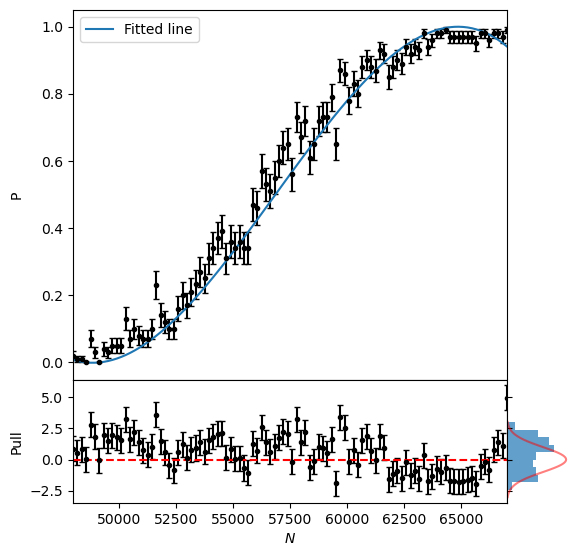

In [4]:
from scipy.stats import norm

pull = (P - third_degree(N, *popt))/P_err

# plot with the original fit
fig, ax = plt.subplots(2, 2, figsize=(6.4,6.4), sharex='col', sharey='row',
    gridspec_kw=dict(hspace=0, wspace=0, height_ratios=(3,1), width_ratios=(7,1)))

# top figure 

ax[0,0].errorbar( N, P, yerr=P_err, capsize=2, fmt='.', c='black')
ax[0,0].plot(N, third_degree(N, *popt), label='Fitted line')
# ax[0,0].errorbar(N, P, yerr=P_err, fmt='o', label='Data')
ax[0,0].set_ylabel('P')

# bottom figure residuals
ax[1,0].errorbar( N, pull, yerr=np.ones_like(N), capsize=2, fmt='.', c='black')
# ax[1,0].errorbar(N, pull, np.ones_like(N), fmt='o', ecolor='lightgray', alpha=0.5)
# borrom figure flat line
ax[1,0].plot(N, np.zeros_like(N), color='r', linestyle='--')
ax[1,0].set_xlabel('$N$')
ax[1,0].set_ylabel('Pull')

# right figure
ax[0,1].set_visible(False)
ax[1,1].hist(pull, bins=10, range=(-3,3), density=True, alpha=0.7, orientation='horizontal')
ax[1,1].xaxis.set_visible(False)
ax[1,1].spines[['top','bottom','right']].set_visible(False)
ax[1,1].tick_params( which='both', direction='in', axis='y', right=False, labelcolor='none')
xp = np.linspace(-3,3,100)
ax[1,1].plot( norm.pdf(xp), xp, 'r-', alpha=0.5 )

# tight x-axis
ax[0,0].autoscale(enable=True, tight=True, axis='x')

ax[0,0].legend()

fig.align_ylabels()

### Goodness of fit test

In [5]:
 ## do a chisq goodness of fit test for the background only
from scipy.stats import chi2
chisq = np.sum( pull**2 )
ndof = len(N) - 4 # number of degrees of freedom
p_value = 1 - chi2.cdf(chisq, ndof)

# --------------
# shld this be a one sided or two sided test?
# --------------
Z = chi2.ppf(1-p_value,1)**0.5 # significance

In [6]:
Z

7.44578812936584